# Seminar 4. Text classification using CNN

## Content
* Data preparation
* Data processing - feature extraction, etc
* CNN & training & evaluation
* What can be improved?

In [1]:
import json
from pathlib import Path
from typing import List

from IPython.display import display, Code
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from tqdm.auto import tqdm

### Data preparation
* Download data from [CodeSearchNet](https://github.com/github/CodeSearchNet#downloading-data-from-s3)
* Unzip & prepare train/valid/test JSONL files
* Read to pandas dataframe

In [2]:
# Download data from CodeSearchNet & extract archives
LANGUAGES = ["ruby", "go", "javascript", "php", "python", "java"]

In [3]:
if False:
    !mkdir dataset
    for lang in LANGUAGES:
        !cd dataset && wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/{lang}.zip && unzip {lang}.zip

    for lang in LANGUAGES:
        !cd dataset && zcat {lang}/final/jsonl/valid/{lang}_valid_0.jsonl.gz >> valid.jsonl
        !cd dataset && zcat {lang}/final/jsonl/test/{lang}_test_0.jsonl.gz >> test.jsonl
        !cd dataset && zcat {lang}/final/jsonl/train/{lang}_train_0.jsonl.gz >> train.jsonl
        !cd dataset && zcat {lang}/final/jsonl/train/{lang}_train_1.jsonl.gz >> train.jsonl
    !cd dataset && shuf train.jsonl > train_shuffled.jsonl
    !cd dataset && shuf test.jsonl > test_shuffled.jsonl
    !cd dataset && shuf valid.jsonl > valid_shuffled.jsonl

Read to pandas dataframe

In [4]:
base_url = Path("dataset")


def read_data(jsonl_loc: str, max_n_rows: int = -1) -> pandas.DataFrame:
    """Read JSONL file to pandas.DataFrame"""
    with open(jsonl_loc) as f:
        data = []
        for i, line in enumerate(f):
            try:
                data.append(json.loads(line))
            except:
                print(f"line {i} has problems")
            if max_n_rows > 0:
                if len(data) >= max_n_rows:
                    break
    return pandas.DataFrame(data)


print("Reading train data...")
df_train = read_data(str(base_url / "train_shuffled.jsonl"), max_n_rows=30000)
print("Reading test data...")
df_test = read_data(str(base_url / "test_shuffled.jsonl"), max_n_rows=30000)
print("Reading validation data...")
df_val = read_data(str(base_url / "valid_shuffled.jsonl"), max_n_rows=30000)

Reading train data...
line 6387 has problems
Reading test data...
line 17581 has problems
Reading validation data...
line 6439 has problems


We can look at some examples from training set

In [5]:
print("Columns in DataFrame:")
df_train.columns

Columns in DataFrame:


Index(['repo', 'path', 'func_name', 'original_string', 'language', 'code',
       'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url',
       'partition'],
      dtype='object')

In [6]:
print("Programming languages:")
df_train["language"].unique()

Programming languages:


array(['javascript', 'java', 'ruby', 'go', 'python', 'php'], dtype=object)

In [7]:
df_train[["language", "func_name", "original_string", "code_tokens"]].head()

,language,func_name,original_string,code_tokens
0,javascript,InvalidValidationRuleParameter,function InvalidValidationRuleParameter(rulePa...,"[function, InvalidValidationRuleParameter, (, ..."
1,java,Strings.pathEquals,"public static boolean pathEquals(String path1,...","[public, static, boolean, pathEquals, (, Strin..."
2,ruby,Phonelib.PhoneFormatter.raw_national,def raw_national\n return nil if sanitize...,"[def, raw_national, return, nil, if, sanitized..."
3,go,WatchSrvVSchema,func (ts *Server) WatchSrvVSchema(ctx context....,"[func, (, ts, *, Server, ), WatchSrvVSchema, (..."
4,javascript,,function (evt) {\n // Ignore input ...,"[function, (, evt, ), {, // Ignore input field..."


We can look at some examples from test set

In [8]:
df_test[["language", "func_name", "original_string", "code_tokens"]].head()

,language,func_name,original_string,code_tokens
0,java,ProjectionPointImpl.isInfinite,static public boolean isInfinite(ProjectionPoi...,"[static, public, boolean, isInfinite, (, Proje..."
1,python,compute_labor_hours,"def compute_labor_hours(sloc, month_hours='coc...","[def, compute_labor_hours, (, sloc, ,, month_h..."
2,java,JNILibrary.deleteTemporaryFiles,private static void deleteTemporaryFiles() {\n...,"[private, static, void, deleteTemporaryFiles, ..."
3,go,GRPCServer,"func GRPCServer(s Server, options ...grpc.Serv...","[func, GRPCServer, (, s, Server, ,, options, ...."
4,php,EloquentBuilder.firstHump,public function firstHump($columns = array('*'...,"[public, function, firstHump, (, $, columns, =..."


Add validate dataset

In [9]:
df_val[["language", "func_name", "original_string", "code_tokens"]].head()

,language,func_name,original_string,code_tokens
0,java,ShadowPackageManager.removeActivity,@Nullable\n public ActivityInfo removeActivit...,"[@, Nullable, public, ActivityInfo, removeActi..."
1,python,_get_well_known_file,"def _get_well_known_file():\n """"""Get the we...","[def, _get_well_known_file, (, ), :, # TODO(or..."
2,php,Recipient.setAsSubscribed,public function setAsSubscribed(\DateTime $sub...,"[public, function, setAsSubscribed, (, \, Date..."
3,python,Core.sendToSbs,"def sendToSbs(self, challenge_id, item_id):\n ...","[def, sendToSbs, (, self, ,, challenge_id, ,, ..."
4,go,DockerClientVersion,func DockerClientVersion(ssh SSHCommander) (st...,"[func, DockerClientVersion, (, ssh, SSHCommand..."


Let's take a look at some functions

In [11]:
def display_code_example(df: pandas.DataFrame, language: str, n_examples: int = 1) -> None:
    """Display example(s) of function from DataFrame"""
    assert n_examples >= 1
    for i, code in enumerate(df_train[df_train["language"] == language]["original_string"]):
        display(Code(code, language=language))
        if i + 1 >= n_examples:
            break

In [12]:
print("Python examples")
display_code_example(df_train, "python", 2)

Python examples


def __build_python_module_cache(self):
        """Recursively walks through the b2/src subdirectories and
        creates an index of base module name to package name. The
        index is stored within self.__python_module_cache and allows
        for an O(1) module lookup.

        For example, given the base module name `toolset`,
        self.__python_module_cache['toolset'] will return
        'b2.build.toolset'

        pkgutil.walk_packages() will find any python package
        provided a directory contains an __init__.py. This has the
        added benefit of allowing libraries to be installed and
        automatically avaiable within the contrib directory.

        *Note*: pkgutil.walk_packages() will import any subpackage
        in order to access its __path__variable. Meaning:
        any initialization code will be run if the package hasn't
        already been imported.
        """
        cache = {}
        for importer, mname, ispkg in pkgutil.walk_packages(b2.__path__, prefix='b2.'):
            basename = mname.split('.')[-1]
            # since the jam code is only going to have "import toolset ;"
            # it doesn't matter if there are separately named "b2.build.toolset" and
            # "b2.contrib.toolset" as it is impossible to know which the user is
            # referring to.
            if basename in cache:
                self.manager.errors()('duplicate module name "{0}" '
                                      'found in boost-build path'.format(basename))
            cache[basename] = mname
        self.__python_module_cache = cache

def _recv(self):
        """Take all available bytes from socket, return list of any responses from parser"""
        recvd = []
        self._lock.acquire()
        if not self._can_send_recv():
            log.warning('%s cannot recv: socket not connected', self)
            self._lock.release()
            return ()

        while len(recvd) < self.config['sock_chunk_buffer_count']:
            try:
                data = self._sock.recv(self.config['sock_chunk_bytes'])
                # We expect socket.recv to raise an exception if there are no
                # bytes available to read from the socket in non-blocking mode.
                # but if the socket is disconnected, we will get empty data
                # without an exception raised
                if not data:
                    log.error('%s: socket disconnected', self)
                    self._lock.release()
                    self.close(error=Errors.KafkaConnectionError('socket disconnected'))
                    return []
                else:
                    recvd.append(data)

            except SSLWantReadError:
                break
            except ConnectionError as e:
                if six.PY2 and e.errno == errno.EWOULDBLOCK:
                    break
                log.exception('%s: Error receiving network data'
                              ' closing socket', self)
                self._lock.release()
                self.close(error=Errors.KafkaConnectionError(e))
                return []
            except BlockingIOError:
                if six.PY3:
                    break
                self._lock.release()
                raise

        recvd_data = b''.join(recvd)
        if self._sensors:
            self._sensors.bytes_received.record(len(recvd_data))

        try:
            responses = self._protocol.receive_bytes(recvd_data)
        except Errors.KafkaProtocolError as e:
            self._lock.release()
            self.close(e)
            return []
        else:
            self._lock.release()
            return responses

In [13]:
print("Java examples")
display_code_example(df_train, "java", 2)

Java examples


public static boolean pathEquals(String path1, String path2) {
        return cleanPath(path1).equals(cleanPath(path2));
    }

@Override
  public Long scard(final byte[] key) {
    checkIsInMultiOrPipeline();
    client.scard(key);
    return client.getIntegerReply();
  }

In [15]:
print("Go examples")
display_code_example(df_train, "go", 2)

Go examples


func (ts *Server) WatchSrvVSchema(ctx context.Context, cell string) (*WatchSrvVSchemaData, <-chan *WatchSrvVSchemaData, CancelFunc) {
	conn, err := ts.ConnForCell(ctx, cell)
	if err != nil {
		return &WatchSrvVSchemaData{Err: err}, nil, nil
	}

	current, wdChannel, cancel := conn.Watch(ctx, SrvVSchemaFile)
	if current.Err != nil {
		return &WatchSrvVSchemaData{Err: current.Err}, nil, nil
	}
	value := &vschemapb.SrvVSchema{}
	if err := proto.Unmarshal(current.Contents, value); err != nil {
		// Cancel the watch, drain channel.
		cancel()
		for range wdChannel {
		}
		return &WatchSrvVSchemaData{Err: vterrors.Wrapf(err, "error unpacking initial SrvVSchema object")}, nil, nil
	}

	changes := make(chan *WatchSrvVSchemaData, 10)

	// The background routine reads any event from the watch channel,
	// translates it, and sends it to the caller.
	// If cancel() is called, the underlying Watch() code will
	// send an ErrInterrupted and then close the channel. We'll
	// just propagate that back to our caller.
	go func() {
		defer close(changes)

		for wd := range wdChannel {
			if wd.Err != nil {
				// Last error value, we're done.
				// wdChannel will be closed right after
				// this, no need to do anything.
				changes <- &WatchSrvVSchemaData{Err: wd.Err}
				return
			}

			value := &vschemapb.SrvVSchema{}
			if err := proto.Unmarshal(wd.Contents, value); err != nil {
				cancel()
				for range wdChannel {
				}
				changes <- &WatchSrvVSchemaData{Err: vterrors.Wrapf(err, "error unpacking SrvVSchema object")}
				return
			}
			changes <- &WatchSrvVSchemaData{Value: value}
		}
	}()

	return &WatchSrvVSchemaData{Value: value}, changes, cancel
}

func (s IntSet) Exist(val int) bool {
	_, ok := s[val]
	return ok
}

In [16]:
print("Ruby examples")
display_code_example(df_train, "ruby", 2)

Ruby examples


def raw_national
      return nil if sanitized.nil? || sanitized.empty?
      if valid?
        @national_number
      elsif country_code && sanitized.start_with?(country_code)
        sanitized[country_code.size..-1]
      else
        sanitized
      end
    end

def scan
    scan_result = Rex::SSLScan::Result.new
    scan_result.openssl_sslv2 = sslv2
    # If we can't get any SSL connection, then don't bother testing
    # individual ciphers.
    if test_ssl == :rejected and test_tls == :rejected
      return scan_result
    end

    threads = []
    ciphers = Queue.new
    @supported_versions.each do |ssl_version|
      sslctx = OpenSSL::SSL::SSLContext.new(ssl_version)
      sslctx.ciphers.each do |cipher_name, ssl_ver, key_length, alg_length|
        threads << Thread.new do
          begin
            status = test_cipher(ssl_version, cipher_name)
            ciphers << [ssl_version, cipher_name, key_length, status]
            if status == :accepted and scan_result.cert.nil?
              scan_result.cert = get_cert(ssl_version, cipher_name)
            end
          rescue Rex::SSLScan::Scanner::InvalidCipher
            next
          end
        end
      end
    end
    threads.each { |thr| thr.join }

    until ciphers.empty? do
      cipher = ciphers.pop
      scan_result.add_cipher(*cipher)
    end
    scan_result
  end

In [17]:
print("PHP examples")
display_code_example(df_train, "php", 2)

PHP examples


public static function getInstance(string $name = 'default'): self
    {
        if (!isset(self::$instances[$name])) {
            self::setInstance($name, new self());
        }

        return self::$instances[$name];
    }

private function createLoginView(array $data)
    {
        // Get the client that we're rendering login for
        $consentType = $this->getConsentType($this->getAuthorizationRequest());

        switch ($consentType) {
            case Client::CONSENT_NONE:
                // Don't set anything if the consent type is "none"
                break;

            case Client::CONSENT_SIMPLE:
            default:
                $data['consentView'] = new View('/oauth/consent/simple');
                break;
        }

        // Start building a view:
        $contents = new View('/oauth/authorize');
        $contents->setViewTheme('concrete');
        $contents->setViewTemplate('background_image.php');
        $contents->addScopeItems($data);

        return $contents;
    }

In [14]:
print("JavaScript examples")
display_code_example(df_train, "javascript", 2)

JavaScript examples


function InvalidValidationRuleParameter(ruleParameter, reason) {
  var defaultMessage = sprintf('%s is not a valid rule parameter.', ruleParameter);
  this.message = reason ? sprintf('%s. %s', defaultMessage, reason) : defaultMessage;
  this.name = 'InvalidValidationRuleParameter';

  Error.captureStackTrace(this, InvalidValidationRuleParameter);
}

function (evt) {
            // Ignore input fields
            if ($(evt.target).is('input')) {
                return true;
            }

            if (evt.shiftKey && 37 <= evt.keyCode && evt.keyCode <= 40) {
                var key = 'key' + evt.keyCode;
                var scrollVals = {
                        key38: [0, -1],
                        key37: [-1, 0],
                        key39: [1, 0],
                        key40: [0, 1]
                    };

                window.scrollBy(scrollVals[key][0], scrollVals[key][1]);
                evt.preventDefault();
            }
        }

## Data processing - feature extraction, etc

Let's create a corpus of the text

Parameters of the task

In [18]:
# Task
MAX_WORDS = 20
MAX_LEN = 40

and find all tokents

In [19]:
if False:
    nltk.download("punkt")

In [20]:
tokens = []
for row in tqdm(df_train["original_string"]):
    tokens.extend(word_tokenize(row))

  0%|          | 0/30000 [00:00<?, ?it/s]

In [21]:
print(f"Total number of tokens in train dataset: {len(tokens)}")

Total number of tokens in train dataset: 4313027


Now let's keep only numbers and words

In [22]:
tokens_filtered = [word for word in tokens if word.isalnum()]
print(f"Total number of alphanumeric tokens in train dataset: {len(tokens_filtered)}")

Total number of alphanumeric tokens in train dataset: 1556038


Collect top N words in the corpus

In [23]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(MAX_WORDS - 1)]

Let's looks at them

In [25]:
tokens_filtered_top

['if',
 'return',
 'the',
 '0',
 'to',
 'function',
 'for',
 'err',
 'in',
 'a',
 'is',
 'nil',
 'var',
 'new',
 'else',
 '1',
 'of',
 'not',
 'end']

Now we are building vocabulary to encode every token using index

In [27]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [28]:
def text_to_sequence(text: str, maxlen: int, vocabulary) -> List[int]:
    """Represent text as list of word indices"""
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0] * (maxlen - len(result))
    return padding + result[-maxlen:]

In [29]:
x_train = np.array([text_to_sequence(text, MAX_LEN) for text in tqdm(df_train["original_string"], 
                                                                     desc="Processing train...")], 
                   dtype=np.int32)
x_test = np.array([text_to_sequence(text, MAX_LEN) for text in tqdm(df_test["original_string"],
                                                                    desc="Processing test...")], 
                  dtype=np.int32)
x_val = np.array([text_to_sequence(text, MAX_LEN) for text in tqdm(df_val["original_string"],
                                                                   desc="Processing validation...")], 
                 dtype=np.int32)

Processing train...:   0%|          | 0/30000 [00:00<?, ?it/s]

Processing test...:   0%|          | 0/30000 [00:00<?, ?it/s]

Processing validation...:   0%|          | 0/30000 [00:00<?, ?it/s]

In [30]:
x_train.shape

(30000, 40)

In [31]:
x_train[:10]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  6, 13, 11, 18, 10],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  2, 12,  1,  1, 15, 19, 19],
       [12,  2,  8, 12, 12,  1,  8,  8, 12,  3,  7,  2,  8,  8, 12, 12,
         3,  3,  5,  3,  1, 11,  3,  3,  5,  7,  1, 12,  5,  8,  2,  1,
         8,  8, 12,  7,  8,  8,  2,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  1,  2,  1, 13, 13,
         4,  4, 16,  4,  4, 16,  4, 16],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
   

Let's prepare class labels

In [32]:
y_train = label_binarize(df_train["language"], classes=LANGUAGES)
y_val = label_binarize(df_val["language"], classes=LANGUAGES)

In [33]:
y_train[:10]

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1]])

In [34]:
y_train.shape

(30000, 6)

## CNN & training & evaluation

In [35]:
# Training
epochs = 10
batch_size = 512
print_batch_n = 20
N_CLASSES = len(LANGUAGES)

In [36]:
import random
import torch
import torch.nn as nn


seed = 1989

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [37]:
class Net(nn.Module):
    def __init__(self, vocab_size: int = 20, embedding_dim: int = 128, out_channel: int = 128, 
                 num_classes: int = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x: torch.Tensor):        
        output = self.embedding(x)  # B F L
        # B - batch, F- filters, L- length 
        #                       B  F  L         
        output = output.permute(0, 2, 1)  # [batch_size, seq_len, emb_size]
        output = self.conv(output)  # [batch_size, seq_len, n_kernels]
        output = self.relu(output)
        output = torch.max(output, axis=2).values # [batch_size, 1, n_kernels]
        output = self.linear(output)
        
        return output

## Training

In [38]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [39]:
model = Net(vocab_size=MAX_WORDS, num_classes=N_CLASSES)

print(model)
print("Number of parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()

if torch.cuda.is_available():
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

    
train_dataset = DataWrapper(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        
        if i % print_batch_n == 0:
            loss = loss.float().item()
            print(f"Step {i}: {loss=}")
            loss_history.append(loss)

Net(
  (embedding): Embedding(20, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=6, bias=True)
)
Number of parameters: 52614
Train epoch 1/10
Step 0: loss=1.853299856185913
Step 20: loss=0.45694583654403687
Step 40: loss=0.39226171374320984
Train epoch 2/10
Step 0: loss=0.374420166015625
Step 20: loss=0.4166843295097351
Step 40: loss=0.3747692108154297
Train epoch 3/10
Step 0: loss=0.33860766887664795
Step 20: loss=0.35656213760375977
Step 40: loss=0.37789976596832275
Train epoch 4/10
Step 0: loss=0.3534092605113983
Step 20: loss=0.35516253113746643
Step 40: loss=0.4435844421386719
Train epoch 5/10
Step 0: loss=0.35153037309646606
Step 20: loss=0.33171185851097107
Step 40: loss=0.3599262237548828
Train epoch 6/10
Step 0: loss=0.38076576590538025
Step 20: loss=0.3479803204536438
Step 40: loss=0.3598201870918274
Train epoch 7/10
Step 0: loss=0.3972699046134949
Step 20: loss=0.3344503939151764
Step 40: loss=

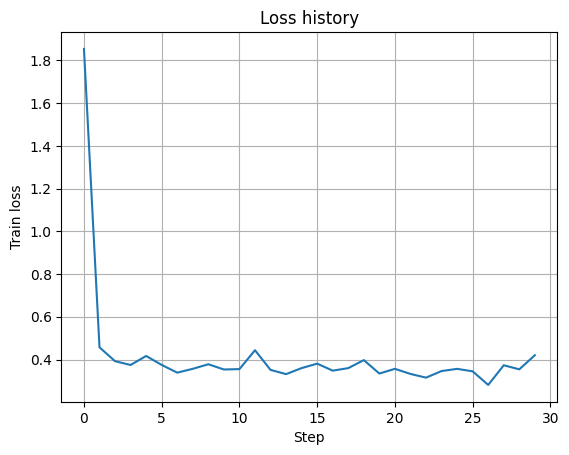

In [40]:
import matplotlib.pyplot as plt
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history)

In [41]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [42]:
def prepare_pred_gt(model, dataloader):
    model.eval()
    pred = []
    labels = []

    for i, (data, target) in enumerate(dataloader):
        # compute output
        pred.extend(model(data).argmax(-1).tolist())
        labels.extend(target.argmax(-1).tolist())
    return pred, labels

In [45]:
train_pred, train_labels = prepare_pred_gt(model, train_loader)
valid_pred, valid_labels = prepare_pred_gt(model, val_loader)
# test_pred, test_labels = prepare_pred_gt(model, test_loader)

In [46]:
def print_metrics(preds, labels):
    print("Accuracy score:", accuracy_score(labels, preds))
    print("Confusion matrix:")
    print(confusion_matrix(labels, preds))

In [47]:
print("Train report:")
print_metrics(train_pred, train_labels)

Accuracy score: 0.8591
Confusion matrix:
[[4161    0    0    0    0    9]
 [   3 3749    1    0  162 1142]
 [   1   10 4050 1151   19   19]
 [   2    6  855 4234   18   20]
 [   5   67   13   27 4858  227]
 [  14  209    7   18  222 4721]]


In [48]:
print("Validation report:")
print_metrics(valid_pred, valid_labels)

Accuracy score: 0.8011666666666667
Confusion matrix:
[[ 727    1    0    0    1   10]
 [   6 2830    5    2  194 1733]
 [   1    9 2056  633   24    6]
 [   8    8 1773 7065   24   45]
 [  39  186   40   56 6923  476]
 [  33  223   29   79  321 4434]]


### What can be improved?
* Based on the previous cell add code to infer your model for a particular input text.
* How can we improve quality?

Ideas:
* Increase MAX_WORDS
* Increase MAX_LEN
* Tokenization - keep all tokens not only alphanumeric
* Do not make lower case

In [52]:
df_train["code_tokens"].apply(lambda p: len(p)).describe()

count    30000.000000
mean       124.309533
std        194.320010
min         18.000000
25%         45.000000
50%         73.000000
75%        136.000000
max      11907.000000
Name: code_tokens, dtype: float64

In [56]:
MAX_WORDS = 160
MAX_LEN = 160

In [57]:
code_tokens = []
for row in df_train["code_tokens"]:
    code_tokens.extend(row)
print("Number of code tokens", len(code_tokens))
dist = FreqDist(code_tokens)
tokens_filtered_top = [pair[0] for pair in dist.most_common(MAX_WORDS - 1)]
print("Most common tokens:")
print("\n".join(tokens_filtered_top))

Number of code tokens 3729286
Most common tokens:
(
)
.
,
=
;
$
}
{
]
[
:
if
return


->
this
"
self
0
*
err
function
+
nil
1
new
:=
i
var
else
==
end
def
::
!
name
null
!=



for
<
=>
in
&&
public
>
options
-
value
data
func
None
||
case
false
true
key
===
|
String
result
e
error
path
string
s
length
?
int
/
c
&
id
not
get
len
array
ret
2
config
params
args
throw
\
type
append
x
context
p
format
+=
''
_
node
try
static
out
raise
final
r
ctx
++
const
v
request
response
!==
is
b
as
opts
log
break
index
m
range
t
a
False
k
do
fmt
map
url
and
n
d
@
obj
kwargs
True
void
f
state
os
item
foreach
message
j
val
logger
join
class
str
size
file
catch
y
time
info
ok
add
Errorf
list
continue
query
res
push


In [72]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

def text_to_sequence(text: str, maxlen: int, vocabulary) -> List[int]:
    """Represent text as list of word indices"""
    result = []
    tokens = word_tokenize(text)
    for word in tokens:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0] * (maxlen - len(result))
    return result[:maxlen] + padding

In [73]:
x_train = np.array([text_to_sequence(text, MAX_LEN, vocabulary) for text in tqdm(df_train["original_string"], 
                                                                     desc="Processing train...")], 
                   dtype=np.int32)
x_test = np.array([text_to_sequence(text, MAX_LEN, vocabulary) for text in tqdm(df_test["original_string"],
                                                                    desc="Processing test...")], 
                  dtype=np.int32)
x_val = np.array([text_to_sequence(text, MAX_LEN, vocabulary) for text in tqdm(df_val["original_string"],
                                                                   desc="Processing validation...")], 
                 dtype=np.int32)

Processing train...:   0%|          | 0/30000 [00:00<?, ?it/s]

Processing test...:   0%|          | 0/30000 [00:00<?, ?it/s]

Processing validation...:   0%|          | 0/30000 [00:00<?, ?it/s]

In [74]:
x_train.shape

(30000, 160)

In [75]:
x_train[:10]

array([[ 23,   1,   4, ...,   0,   0,   0],
       [ 46,  97,   1, ...,   0,   0,   0],
       [ 34,  14,  25, ...,   0,   0,   0],
       ...,
       [ 23,   1,   2, ...,   0,   0,   0],
       [ 52,   1,  67, ...,   0,   0,   0],
       [129,  46,   1, ...,   0,   0,   0]], dtype=int32)

In [76]:
model = Net(vocab_size=MAX_WORDS, num_classes=N_CLASSES)

print(model)
print("Number of parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()

if torch.cuda.is_available():
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

    
train_dataset = DataWrapper(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        
        if i % print_batch_n == 0:
            loss = loss.float().item()
            print(f"Step {i}: {loss=}")
            loss_history.append(loss)

Net(
  (embedding): Embedding(160, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=6, bias=True)
)
Number of parameters: 70534
Train epoch 1/10
Step 0: loss=2.070568323135376
Step 20: loss=0.016902582719922066
Step 40: loss=0.01334077212959528
Train epoch 2/10
Step 0: loss=0.01021402794867754
Step 20: loss=0.005280562210828066
Step 40: loss=0.0009608141263015568
Train epoch 3/10
Step 0: loss=0.0009437274420633912
Step 20: loss=0.0005775713361799717
Step 40: loss=0.0006676899502053857
Train epoch 4/10
Step 0: loss=0.001070017577148974
Step 20: loss=0.000497232424095273
Step 40: loss=0.0011325253872200847
Train epoch 5/10
Step 0: loss=0.00028872204711660743
Step 20: loss=0.001020621508359909
Step 40: loss=0.0006785382283851504
Train epoch 6/10
Step 0: loss=0.0007587990839965641
Step 20: loss=0.00020382856018841267
Step 40: loss=0.0005834524054080248
Train epoch 7/10
Step 0: loss=6.426809704862535e-05
Step 20

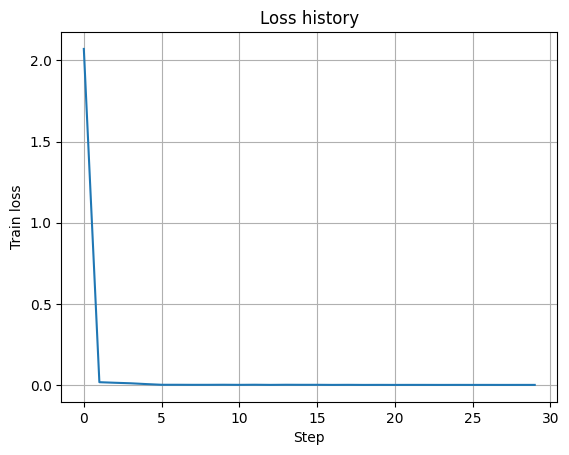

In [77]:
import matplotlib.pyplot as plt
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history)

In [78]:
train_pred, train_labels = prepare_pred_gt(model, train_loader)
valid_pred, valid_labels = prepare_pred_gt(model, val_loader)

print("Train report:")
print_metrics(train_pred, train_labels)

print("Validation report:")
print_metrics(valid_pred, valid_labels)

Train report:
Accuracy score: 1.0
Confusion matrix:
[[4170    0    0    0    0    0]
 [   0 5057    0    0    0    0]
 [   0    0 5250    0    0    0]
 [   0    0    0 5135    0    0]
 [   0    0    0    0 5197    0]
 [   0    0    0    0    0 5191]]
Validation report:
Accuracy score: 0.9992666666666666
Confusion matrix:
[[ 739    0    0    0    0    0]
 [   0 4770    0    0    0    0]
 [   0    0 2727    2    0    0]
 [   0    0   10 8913    0    0]
 [   4    0    1    0 7715    0]
 [   0    0    4    1    0 5114]]


In [70]:
LANGUAGES[2:4]

['javascript', 'php']

In [71]:
LANGUAGES[0], LANGUAGES[4]

('ruby', 'python')